# Phase 4 Project: Skin Condition Classification
## Technical Modeling Notebook
### Authored by Trinity Gahagen
---
---

This notebook and the modeling notebook both work with the Skin Condition image dataset found on this [Kaggle page](https://www.kaggle.com/datasets/syedalinaqvi/augmented-skin-conditions-image-dataset).

# Basic Imports
---

In [53]:
# Basic Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os
from glob import glob

# Plotting Tools
import colorcet as cc
from matplotlib.ticker import FuncFormatter

# Classical ML Models and Tools
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, roc_auc_score, roc_curve, classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import xgboost as xgb
from sklearn.pipeline import Pipeline

# HOG tools
from skimage.feature import hog
from skimage import exposure

# Neural Network Models and Tools


In [2]:
PARENT_DIRECTORY = "../Skin_Conditions/"

# Classical ML Approach: Preprocessing Functions and Testing
---

In [29]:
# Create a bunch of functions to try and get this data in
def preprocess_image(image_path, r_height=300, r_width=300):
    # Read in image and convert to grayscale
    img = cv2.imread(image_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Resize to send into HOG feature extraction
    final_img = cv2.resize(gray, (r_height, r_width), interpolation=cv2.INTER_LINEAR)

    return final_img


def get_hog_features(image, orientations=9, ppc=(10, 10), cpb=(2,2), vis=True, norm_strat='L2-Hys'):
    # Perform HOG feature extraction on images
    return_list = hog(image=image,
                      orientations=orientations,
                      pixels_per_cell=ppc,
                      cells_per_block=cpb,
                      visualize=vis,
                      block_norm=norm_strat)

    hog_features = return_list[0]
    if vis:
        hog_image = return_list[1]
        return hog_features, hog_image
    else:
        return hog_features

In [30]:
# Test out HOG function to see if it works
test_image = preprocess_image(os.path.join(PARENT_DIRECTORY, 'Acne/Acne_1.jpg'))

fd, hog_image = get_hog_features(test_image, vis=True)

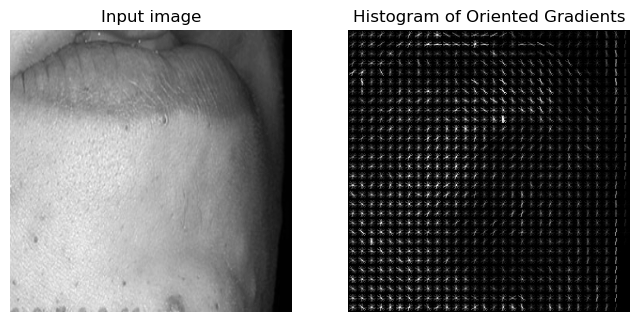

In [31]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)

ax1.axis('off')
ax1.imshow(test_image, cmap=plt.cm.gray)
ax1.set_title('Input image')

# Rescale histogram for better display
hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))

ax2.axis('off')
ax2.imshow(hog_image_rescaled, cmap=plt.cm.gray)
ax2.set_title('Histogram of Oriented Gradients')
plt.show()

In [32]:
print(test_image.shape)

(300, 300)


Both functions apppear to work correctly; now it's time to create a dataset of HOG features and their labels in order to create, train, and test a machine learning classifier.

# Classical ML Approach
---

In [23]:
subdirectories = [os.path.join(PARENT_DIRECTORY, d) for d in os.listdir(PARENT_DIRECTORY) if os.path.isdir(os.path.join(PARENT_DIRECTORY, d))]
class_labels = [d for d in os.listdir(PARENT_DIRECTORY) if os.path.isdir(os.path.join(PARENT_DIRECTORY, d))]
display(subdirectories)
display(class_labels)

['../Skin_Conditions/Acne',
 '../Skin_Conditions/Carcinoma',
 '../Skin_Conditions/Eczema',
 '../Skin_Conditions/Keratosis',
 '../Skin_Conditions/Milia',
 '../Skin_Conditions/Rosacea']

['Acne', 'Carcinoma', 'Eczema', 'Keratosis', 'Milia', 'Rosacea']

In [51]:
try:
    hog_feature_dataset = pd.read_csv('hog_feature_dataset.csv')
except:
    X = []
    y = []

    for n in range(len(subdirectories)):
        image_paths = os.listdir(subdirectories[n])
        label = class_labels[n]

        for image_name in image_paths:
            image = preprocess_image(os.path.join(subdirectories[n], image_name))
            features, _ = get_hog_features(image, vis=True)
            X.append(features)
            y.append(label)
    
    hog_feature_dataset = pd.DataFrame({'features': X, 'labels': y})
    hog_feature_dataset.to_csv('hog_feature_dataset.csv')

In [52]:
hog_feature_dataset.head()

,features,labels
0,"[0.2310473850100315, 0.07300499508488964, 0.23...",Acne
1,"[0.21546976814853025, 0.05429528654482285, 0.0...",Acne
2,"[0.3070826653861073, 0.09654231447198952, 0.16...",Acne
3,"[0.2856364872083225, 0.23252910130759047, 0.09...",Acne
4,"[0.13556809121726754, 0.13100613650255594, 0.1...",Acne


In [ ]:
X = hog_feature_dataset['features']
y = hog_feature_dataset['labels']

shotgun_approach = {
    'knn' : {
        'model' : KNeighborsClassifier(),
        'metric' : []
    },
    'svc' : {
        'model' : SVC(),
        'metric' : []
    },
    'xgb' : {
        'model' : xgb.XGBClassifier(objective='multi:softmax'),
        'metric' : []
    },
    'rand_forest' : {
        'model' : RandomForestClassifier(),
        'metric' : []
    }
}



# External Resources
---
https://selfdriving5.github.io/udacity/Self-Driving%20Car%20Engineer%20v5.0.0(us)/Part%2003-Module%2001-Lesson%2001_Object%20Detection/20.%20scikit-image%20HOG.html

https://machinelearningmastery.com/opencv_hog/

https://scikit-image.org/docs/stable/api/skimage.feature.html#skimage.feature.hog

https://medium.com/swlh/histogram-of-oriented-gradients-hog-for-multiclass-image-classification-and-image-recommendation-cf0ea2caaae8

https://customers.pyimagesearch.com/lesson-sample-histogram-of-oriented-gradients-and-car-logo-recognition/